In [1]:
%matplotlib inline
# Load all necessary packages
import sys
sys.path.append("../")
from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector

from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
    import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas

from aif360.algorithms.preprocessing.lfr import LFR

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import numpy as np


In [2]:
## import dataset
dataset_used = "german" # "adult", "german", "compas"
protected_attribute_used = 2 # 1, 2

if dataset_used == "adult":
#    dataset_orig = AdultDataset()
    dataset_orig = load_preproc_data_adult()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
    
elif dataset_used == "german":
    dataset_orig = GermanDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
    else:
        privileged_groups = [{'age': 1}]
        unprivileged_groups = [{'age': 0}]
        
    for i in range(1000):
        if (dataset_orig.labels[i] == 2.0):
            dataset_orig.labels[i] = 0
        else:
            dataset_orig.labels[i] = 1
        
    dataset_orig.favorable_label = 1
    dataset_orig.unfavorable_label = 0

    
elif dataset_used == "compas":
#     dataset_orig = CompasDataset()
    dataset_orig = load_preproc_data_compas()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}] 

#Splitting train and test set
dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)

In [3]:
#It finds that if the dataset has a class imbalance, in terms of positive and negative outcomes.
k=0
for i in range(len(dataset_orig.labels)):
    if(dataset_orig.labels[i] == 1):
        k+=1
    else:
        pass
print(k)

700


In [4]:
# some information of each dataset regarding labels, names, etc. 
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(700, 58)


#### Favorable and unfavorable labels

1 0


#### Protected attribute names

['sex', 'age']


#### Privileged and unprivileged protected attribute values

[array([1.]), array([1.])] [array([0.]), array([0.])]


#### Dataset feature names

['month', 'credit_amount', 'investment_as_income_percentage', 'residence_since', 'age', 'number_of_credits', 'people_liable_for', 'sex', 'status=A11', 'status=A12', 'status=A13', 'status=A14', 'credit_history=A30', 'credit_history=A31', 'credit_history=A32', 'credit_history=A33', 'credit_history=A34', 'purpose=A40', 'purpose=A41', 'purpose=A410', 'purpose=A42', 'purpose=A43', 'purpose=A44', 'purpose=A45', 'purpose=A46', 'purpose=A48', 'purpose=A49', 'savings=A61', 'savings=A62', 'savings=A63', 'savings=A64', 'savings=A65', 'employment=A71', 'employment=A72', 'employment=A73', 'employment=A74', 'employment=A75', 'other_debtors=A101', 'other_debtors=A102', 'other_debtors=A103', 'property=A121', 'property=A122', 'property=A123', 'property=A124', 'installment_plans=A141', 'installment_plans=A142', 'installment_plans=A143', 'housing=A151', 'housing=A152', 'housing=A153', 'skill_level=A171', 'skill_level=A172', 'skill_level=A173', 'skill_level=A174', 'telephone=A191', 'telephone=A192', 'fore

In [5]:
# Initial disparities in the original datasets

metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

display(Markdown("#### %s original training dataset"%dataset_used))
print("Disparate impact (of original labels) between unprivileged and privileged groups = %f" % metric_orig_train.disparate_impact())
print("Difference in statistical parity (of original labels) between unprivileged and privileged groups = %f" % metric_orig_train.statistical_parity_difference())
print("Individual fairness metric from Zemel et.al. that measures how similar the labels are for similar instances = %f" % metric_orig_train.consistency())

metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

display(Markdown("#### %s original test dataset"%dataset_used))
print("Disparate impact (of original labels) between unprivileged and privileged groups = %f" % metric_orig_test.disparate_impact())
print("Difference in statistical parity (of original labels) between unprivileged and privileged groups = %f" % metric_orig_test.statistical_parity_difference())
print("Individual fairness metric from Zemel et.al. that measures how similar the labels are for similar instances = %f" % metric_orig_test.consistency())


#### german original training dataset

Disparate impact (of original labels) between unprivileged and privileged groups = 0.744820
Difference in statistical parity (of original labels) between unprivileged and privileged groups = -0.185911
Individual fairness metric from Zemel et.al. that measures how similar the labels are for similar instances = 0.674571


c:\users\hatta\anaconda3\envs\aif360\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_neighbors=5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


#### german original test dataset

Disparate impact (of original labels) between unprivileged and privileged groups = 0.900697
Difference in statistical parity (of original labels) between unprivileged and privileged groups = -0.072296
Individual fairness metric from Zemel et.al. that measures how similar the labels are for similar instances = 0.688000


c:\users\hatta\anaconda3\envs\aif360\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_neighbors=5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [6]:
#Scaling the dataset
scale_orig = StandardScaler()

X_train = scale_orig.fit_transform(dataset_orig_train.features)
X_test = scale_orig.transform(dataset_orig_test.features)

y_train = dataset_orig_train.labels.ravel()
y_test = dataset_orig_test.labels.ravel()

#Logistic Regression Training for each dataset
log_reg = LogisticRegression() 

#Fitting the training set
log_reg.fit(X_train, y_train)

#Predicting test set labels
y_test_pred = log_reg.predict(X_test)
y_test_pred_proba = log_reg.predict_proba(X_test)

#### Fairness performance of the predicted labels without mitigation

In [7]:
display(Markdown("#### LR predictions of %s Test Set: Fairness Performance Results"%dataset_used))

#Create a new version of the test set with predicted class labels
testset_pred = dataset_orig_test.copy()
testset_pred.labels = y_test_pred

#Construction 1
#to construct this metric function, the predicted labels should be united with the test fetures to make a new datas
metric_pred_test = BinaryLabelDatasetMetric(testset_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
#Construction 2
#both original test dataset with actual labels and the test dataset combined with predicted class labels need to be given to this function
classified_metric = ClassificationMetric(dataset_orig_test, 
                                                 testset_pred,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)


#Checking Equalized Odds: average odds differecence, which is the avg. of differences in FPR&TPR for privileged and unprivileged groups.
aeo = classified_metric.average_odds_difference()
print("Average equalized odds difference between unprivileged and privileged groups = %f" % aeo)

#Disparate Impact ratio between privileged and unprivileged groups.
di = classified_metric.disparate_impact()
print("Disparate impact ratio between unprivileged and privileged groups = %f" % di)

#Demographic parity difference between privileged and unprivileged groups.
spd = classified_metric.statistical_parity_difference()
print("Demographic parity difference between unprivileged and privileged groups = %f" % spd)

#Predictive parity difference: PPV difference between privileged and unprivileged groups.
ppd = classified_metric.positive_predictive_value(privileged=False) - classified_metric.positive_predictive_value(privileged=True)
print("Predictive Parity difference between unprivileged and privileged groups = %f" % ppd)

#Individual Fairness: 1)Consistency, 2) Euclidean Distance between individuals.
print("Consistency of indivuals' predicted labels = %f" % metric_pred_test.consistency())

TPR = classified_metric.true_positive_rate() #recall
TNR = classified_metric.true_negative_rate() #specificity
PPV = classified_metric.positive_predictive_value() #precision
bal_acc = (TPR+TNR)/2
f1 = 2*((PPV*TPR)/(PPV+TPR))

display(Markdown("#### LR Prediction Performance on %s Test Set"%dataset_used))
print("Standard accuracy of logistic regression trained on German dataset without any mitigation = %f" % classified_metric.accuracy())
print("Balanced accuracy of logistic regression trained on German dataset without any mitigation = %f" % bal_acc)
print("F1 score of logistic regression trained on German dataset without any mitigation = %f" % f1)

print("For german dataset")
print("Precision (PPV): %f" %PPV)
print("Recall (TPR): %f" %TPR)
print("Specificity (TNR): %f" %TNR)

#### LR predictions of german Test Set: Fairness Performance Results

Average equalized odds difference between unprivileged and privileged groups = -0.209907
Disparate impact ratio between unprivileged and privileged groups = 0.679659
Demographic parity difference between unprivileged and privileged groups = -0.262707
Predictive Parity difference between unprivileged and privileged groups = -0.081032
Consistency of indivuals' predicted labels = 0.713333


c:\users\hatta\anaconda3\envs\aif360\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_neighbors=5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


#### LR Prediction Performance on german Test Set

Standard accuracy of logistic regression trained on German dataset without any mitigation = 0.753333
Balanced accuracy of logistic regression trained on German dataset without any mitigation = 0.670615
F1 score of logistic regression trained on German dataset without any mitigation = 0.833333
For german dataset
Precision (PPV): 0.804348
Recall (TPR): 0.864486
Specificity (TNR): 0.476744


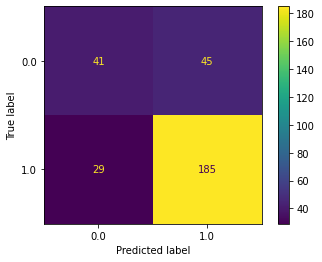

In [8]:
cm_orig = confusion_matrix(dataset_orig_test.labels, testset_pred.labels)

disp_orig = ConfusionMatrixDisplay(confusion_matrix=cm_orig,
                              display_labels=log_reg.classes_)
disp_orig.plot()

### Implementation of Learning Fair Represenrations Algorithm

In [9]:
#1) Transforming Adult Dataset

#Required Inputs:
# Input recontruction quality - Ax
# Fairness constraint - Az
# Output prediction error - Ay

#scaled dataset together with its labels is needed
dataset_orig_train.features = scale_orig.fit_transform(dataset_orig_train.features)
dataset_orig_test.features = scale_orig.transform(dataset_orig_test.features)

#LFR itself contains logistic regression sinc it uses signoid functions 
LFR =LFR(unprivileged_groups=unprivileged_groups,
         privileged_groups=privileged_groups,
         k=5, Ax=0.1, Ay=1.0, Az=100.0, verbose=1)

TR = LFR.fit(dataset_orig_train, maxiter=5000, maxfun=5000)

# Transform training data and align features
dataset_transf_train = TR.transform(dataset_orig_train)
#a_transf_test = TR_a.transform(adult_orig_test)

c:\users\hatta\anaconda3\envs\aif360\lib\site-packages\aif360\algorithms\preprocessing\lfr_helpers\helpers.py:62: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "LFR_optim_obj" failed type inference due to: Unknown attribute 'iters' of type recursive(type(CPUDispatcher(<function LFR_optim_obj at 0x000001E896B0C9D8>)))

File "..\..\..\..\anaconda3\envs\aif360\lib\site-packages\aif360\algorithms\preprocessing\lfr_helpers\helpers.py", line 66:
def LFR_optim_obj(params, data_sensitive, data_nonsensitive, y_sensitive,
    <source elided>

    LFR_optim_obj.iters += 1
    ^

[1] During: typing of get attribute at c:\users\hatta\anaconda3\envs\aif360\lib\site-packages\aif360\algorithms\preprocessing\lfr_helpers\helpers.py (66)

File "..\..\..\..\anaconda3\envs\aif360\lib\site-packages\aif360\algorithms\preprocessing\lfr_helpers\helpers.py", line 66:
def LFR_optim_obj(params, data_sensitive, data_nonsensitive, y_sensitive,
    <source elided

250 5429.2547597280745
500 5181.880613027107
750 5181.880690387563
1000 5063.016636443756
1250 5176.2366195427785
1500 5176.236875121079
1750 4719.054296809685
2000 4719.054323682544
2250 4397.456354985086
2500 4684.0108847738675
2750 4684.010943226902
3000 4347.121806696803
3250 4347.121920133898
3500 4315.103935306959
3750 4268.176217976064
4000 4268.176281290303
4250 4221.6372286150745
4500 4221.637250793688
4750 4176.656549597286
5000 4199.117470580807
5250 4199.117331902985
5500 4167.0962727762835
5750 4167.096116024622


c:\users\hatta\anaconda3\envs\aif360\lib\site-packages\aif360\algorithms\preprocessing\lfr_helpers\helpers.py:50: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "yhat" failed type inference due to: Invalid use of Function(<built-in function iadd>) with argument(s) of type(s): (float64, array(float64, 1d, C))
Known signatures:
 * (int64, int64) -> int64
 * (int64, uint64) -> int64
 * (uint64, int64) -> int64
 * (uint64, uint64) -> uint64
 * (float32, float32) -> float32
 * (float64, float64) -> float64
 * (complex64, complex64) -> complex64
 * (complex128, complex128) -> complex128
 * parameterized
In definition 0:
    All templates rejected with literals.
In definition 1:
    All templates rejected without literals.
In definition 2:
    All templates rejected with literals.
In definition 3:
    All templates rejected without literals.
In definition 4:
    All templates rejected with literals.
In definition 5:
    All templates reject

In [10]:
#check if the labels are transformed: counts the num. of transformed labels
k=0
for i in range(len(dataset_orig_train.labels)):
    if(dataset_transf_train.labels[i] == dataset_orig_train.labels[i]):
        pass
    else:
        k+=1
        
k

205

In [11]:
#copying transformed features and pasting original labels to them
transf_train_new = dataset_orig_train.copy(deepcopy=True)
transf_train_new.scores = dataset_transf_train.scores

### Evaluation of LFR

In [12]:
#Fairness Performance of Datasets Before Classification

#Constucting two functions to call the desired metrics
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

display(Markdown("#### Transformed %s train set"%dataset_used))
print("Disparate impact ratio (of transformed labels) between unprivileged and privileged groups = %f" % metric_transf_train.disparate_impact())
print("Difference in statistical parity (of transformed labels) between unprivileged and privileged groups = %f" % metric_transf_train.statistical_parity_difference())
print("Individual fairness metric 'consistency' that measures how similar the labels are for similar instances = %f" % metric_transf_train.consistency())

#### Transformed german train set

Disparate impact ratio (of transformed labels) between unprivileged and privileged groups = 1.000262
Difference in statistical parity (of transformed labels) between unprivileged and privileged groups = 0.000258
Individual fairness metric 'consistency' that measures how similar the labels are for similar instances = 0.998000


c:\users\hatta\anaconda3\envs\aif360\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_neighbors=5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


#### Training logistic regression with transformed dataset and predicting test set

In [13]:
X_train_trans =dataset_transf_train.features
X_test_trans = dataset_orig_test.features

y_train_trans = dataset_transf_train.labels.ravel()
y_test_trans = dataset_orig_test.labels.ravel() 


#Logistic Regression Training with the transformed dataset
trans_lr = LogisticRegression()

#fitting the model
trans_lr.fit(X_train_trans, y_train_trans)

#Predicting test set labels
y_test_trans_pred = trans_lr.predict(X_test_trans)
y_test_trans_pred_proba = trans_lr.predict_proba(X_test_trans)

In [14]:
#Create a new version of the transformed test set with predicted class labels
testset_pred_trans = dataset_orig_test.copy()
testset_pred_trans.labels = y_test_trans_pred

In [15]:
#Performance Metrics from the dataset predictions

metric_trans_test = BinaryLabelDatasetMetric(testset_pred_trans, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

classified_trans_test = ClassificationMetric(dataset_orig_test, 
                                                 testset_pred_trans,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)


display(Markdown("#### (Pre-processed) LR with %s Test Set Fairness Performance (based on predictions)"%dataset_used))

#Checking Equalized Odds: average odds differecence, which is the avg. of differences in FPR&TPR for privileged and unprivileged groups.
deb_aeo_t = classified_trans_test.average_odds_difference()
print("Average equalized odds difference between unprivileged and privileged groups = %f" % deb_aeo_t)

#Disparate Impact ratio between privileged and unprivileged groups.
deb_di_t = classified_trans_test.disparate_impact()
print("Disparate impact ratio between unprivileged and privileged groups = %f" % deb_di_t)

#Demographic parity difference between privileged and unprivileged groups.
deb_spd_t = classified_trans_test.statistical_parity_difference()
print("Demographic parity difference between unprivileged and privileged groups = %f" % deb_spd_t)

#Predictive parity difference: PPV difference between privileged and unprivileged groups.
deb_ppd_t = classified_trans_test.positive_predictive_value(privileged=False) - classified_trans_test.positive_predictive_value(privileged=True)
print("Predictive Parity difference between unprivileged and privileged groups = %f" % deb_ppd_t)

#Individual Fairness: 1)Consistency, 2) Euclidean Distance between individuals.
print("Consistency of indivuals' predicted labels = %f" % metric_trans_test.consistency())


#Prediction performance metrics
TPR_t = classified_trans_test.true_positive_rate() #recall
TNR_t = classified_trans_test.true_negative_rate() #specificity
PPV_t = classified_trans_test.positive_predictive_value() #precision
bal_acc_t = (TPR_t+TNR_t)/2
f1_t = 2*((PPV_t*TPR_t)/(PPV_t+TPR_t))

display(Markdown("#### (Pre-processed) LR with %s Test Set Prediction Performance"%dataset_used))
print("Standard accuracy of logistic regression trained on test set with debiasing = %f" % classified_trans_test.accuracy())
print("Balanced accuracy of logistic regression trained on test set  with debiasing = %f" % bal_acc_t)
print("F1 score of logistic regression trained on test set with debiasing = %f" % f1_t)

print("Detailed scores for %s test set"%dataset_used)
print("Precision (PPV): %f" %PPV_t)
print("Recall (TPR): %f" %TPR_t)
print("Specificity (TNR): %f" %TNR_t)

#### (Pre-processed) LR with german Test Set Fairness Performance (based on predictions)

Average equalized odds difference between unprivileged and privileged groups = 0.048939
Disparate impact ratio between unprivileged and privileged groups = 1.052863
Demographic parity difference between unprivileged and privileged groups = 0.050209
Predictive Parity difference between unprivileged and privileged groups = -0.071135
Consistency of indivuals' predicted labels = 0.964000


c:\users\hatta\anaconda3\envs\aif360\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_neighbors=5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


#### (Pre-processed) LR with german Test Set Prediction Performance

Standard accuracy of logistic regression trained on test set with debiasing = 0.693333
Balanced accuracy of logistic regression trained on test set  with debiasing = 0.496414
F1 score of logistic regression trained on test set with debiasing = 0.816733
Detailed scores for german test set
Precision (PPV): 0.711806
Recall (TPR): 0.957944
Specificity (TNR): 0.034884


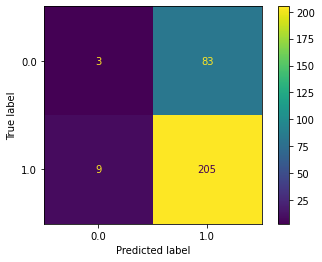

In [16]:
cm_trans = confusion_matrix(dataset_orig_test.labels, testset_pred_trans.labels)

disp_trans = ConfusionMatrixDisplay(confusion_matrix=cm_trans,
                              display_labels=trans_lr.classes_)
disp_trans.plot() 